In [1]:
from HH_Lukas import HouseholdSpecializationModelClass as HC
from types import SimpleNamespace
import numpy as np  
from scipy import optimize
import ipywidgets as widgets
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import cm
%load_ext autoreload
%autoreload 2

## Question 1

#### Testing
First, we solve for one set of parameters. Later on, we'll build up a loop.  

In [2]:
a = HC() #Import the whole model
a.par.alpha = 0.25 #Set parameters
a.par.sigma = 0.5
a_1 = a.solve_discrete() #solve the model


#Get hours worked for females and males and compute ratio
HF_1 = a_1.HF  
HM_1 = a_1.HM
HFHM_1=HF_1/HM_1
print('The ratio of female to male hours worked at home is ', HFHM_1)


/Users/l/Desktop/Programming/Intro_Num-1/HH_Lukas.py:67: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**(power1)+par.alpha*HF**(power1))**(power2)
/Users/l/Desktop/Programming/Intro_Num-1/HH_Lukas.py:67: RuntimeWarning: invalid value encountered in reciprocal
  H = ((1-par.alpha)*HM**(power1)+par.alpha*HF**(power1))**(power2)
/Users/l/Desktop/Programming/Intro_Num-1/HH_Lukas.py:71: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-4)**(1-par.rho)/(1-par.rho)


The ratio of female to male hours worked at home is  0.5454545454545454


### Loop

#### Initialize

In [3]:
#Parameters
alphas = np.array([0.25, 0.5, 0.75])
sigmas = np.array([0.5, 1.0, 1.5])
#Initialize arrays for hours worked at home for males and females
HM = np.zeros(9) 
HF = np.zeros(9)

#### Indexing
Figure out an index for all nine possible combinations of the parameters. The combinations can be found using the Cartesian product of the "alphas" and "sigmas" arrays.


In [4]:
for i, val1 in enumerate(alphas): 
    for j, val2 in enumerate(sigmas):
        index = i * len(sigmas) + j
        print(index, '=',i, '*', len(sigmas), '+', j)

0 = 0 * 3 + 0
1 = 0 * 3 + 1
2 = 0 * 3 + 2
3 = 1 * 3 + 0
4 = 1 * 3 + 1
5 = 1 * 3 + 2
6 = 2 * 3 + 0
7 = 2 * 3 + 1
8 = 2 * 3 + 2


In [5]:
print('Example: the combination of the alpha with position 1 (0.5) and the sigma with position 2 (1.5) will land in position', 1* len(sigmas) + 2  )

Example: the combination of the alpha with position 1 (0.5) and the sigma with position 2 (1.5) will land in position 5


### Loop

In [6]:
for i, val1 in enumerate(alphas): 
    a.par.alpha = val1  #Set the parameter of outer loop
    for j, val2 in enumerate(sigmas):
        a.par.sigma = val2 #Set parameter of inner loop 
        index = i * len(sigmas) + j 
        HM[index] = a.solve_discrete().HM #Solve and extract hours worked at home
        HF[index] = a.solve_discrete().HF

Home_ratios = (HF/HM).reshape((3,3))
print(Home_ratios)

[[0.54545455 0.30769231 0.21428571]
 [1.         1.         1.        ]
 [1.83333333 3.25       4.66666667]]


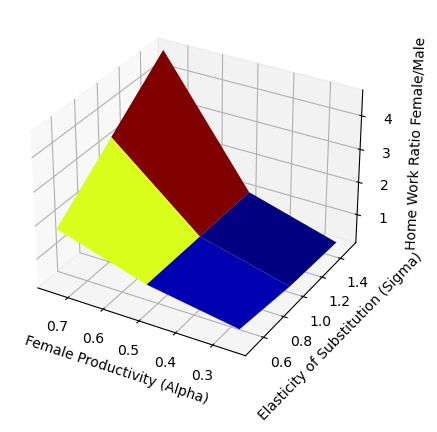

In [7]:

alphas_grid, sigmas_grid = np.meshgrid(alphas,sigmas,indexing='ij') #Prepare 3d plot by repeating each value in the arrays sigmas and alphas
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
#ax.set_xlabel('Alphas')
ax.set_xlabel(xlabel= 'Female Productivity (Alpha)')
ax.set_ylabel('Elasticity of Substitution (Sigma)')
ax.set_zlabel('        Home Work Ratio Female/Male')
ax.invert_xaxis() #So Origo is in the front right corner
ax.plot_surface(alphas_grid,sigmas_grid,Home_ratios,cmap=cm.jet)


### Interpretation
Here we see that when female and male productivity are equal (alpha = 0.5) and their labor is highly subsititutable (high sigma), the ratio of home work is around 1. Implying equal division of chores. On the other hand, if men are more productive at home chores (alpha < 0.5) they will work more than females (ratio below 1) given a high elasticity of substituition. 

## Question 2
Log-log plotting the optimal ratio of home work for different levels of female wages.

[1.25       1.         1.         0.88888889 0.8       ]


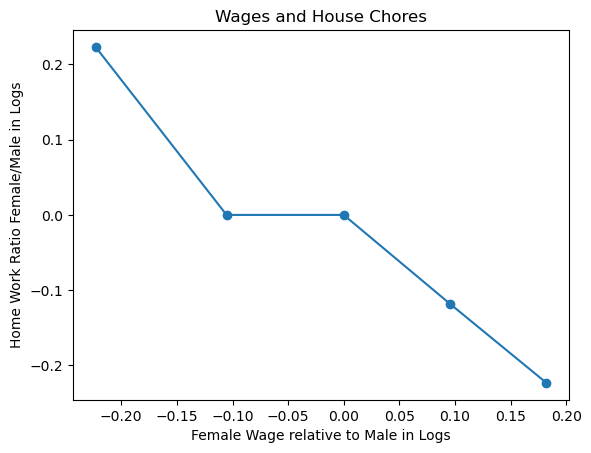

In [8]:
a.par.alpha = 0.5 #Re-set parameters
a.par.sigma = 1
assert np.array_equal(a.par.wF_vec, np.linspace(0.8, 1.2, 5)) #Check we have the correct array of female wages stored
a.solve_wF_vec(discrete=True) #Loops through the values, solves the model and stores the hours worked at home. 
Home_ratios = a.sol.HF_HM_Ratio #Above function returns the Home_ratios vector
print(Home_ratios)
fig, ax = plt.subplots() #Start plotting
ax.plot( np.log(a.par.wF_vec), np.log(Home_ratios),'o-') #As male wage is equal to one, division is not necessary. 

ax.set_ylabel('Home Work Ratio Female/Male in Logs')
ax.set_xlabel('Female Wage relative to Male in Logs')
ax.set_title('Wages and House Chores')

plt.show()

#### Interpretation

As expected, when female wage is high relative to mens', females pick up less home work and vice versa. 

## Question 3
In the continous choice set of labor allocated, we use a gradient based optimizer. These types of optimizers depend on the starting point. For types of work for males and females, we chose the averages for different types of female wages as found from the discrete solution.

In [9]:
average_guess = [a.sol.LM_vec.mean().round(2),a.sol.HM_vec.mean().round(2) ,a.sol.LF_vec.mean().round(2), a.sol.HF_vec.mean().round(2)]
print('We used the average ratios as an initial guess', a.par.guess) 

We used the average ratios as an initial guess [4.5, 4.4, 4.37, 4.53]


#### Looping through and plotting

[1.25001469 1.11110588 0.99999822 0.90909651 0.83332878]


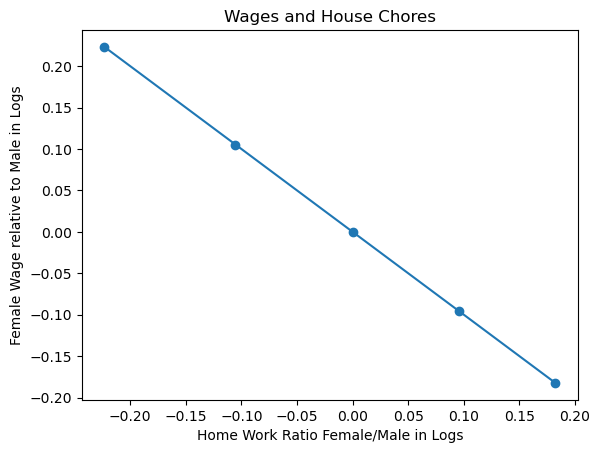

In [10]:
a.par.guess = average_guess
assert np.array_equal(a.par.guess, average_guess)
assert np.array_equal(a.par.wF_vec, np.linspace(0.8, 1.2, 5)) #Check we have the correct array of female wages stored
a.solve_wF_vec(discrete=False) #Loops through the values, solves the model and stores the hours worked at home. 


Home_ratios = a.sol.HF_HM_Ratio #Above function returns the Home_ratios vector
print(Home_ratios)

fig, ax = plt.subplots() #Start plotting
ax.plot(np.log(a.par.wF_vec/a.par.wM), np.log(Home_ratios),'o-') #As male wage is equal to one, division is not necessary. 

ax.set_xlabel('Home Work Ratio Female/Male in Logs')
ax.set_ylabel('Female Wage relative to Male in Logs')
ax.set_title('Wages and House Chores')

plt.show()

#### Interpretation
Here again, we see that if females earn higher wages outside, they work less in the home. Contrary to the discrete case, we do not observe jumps in the work provided. 
Note that in our example, the labor provided by males and females is equally productive at home and perfectly substitutable (sigma = 1 and alpha 0.5). This implies that equal wage should lead to equal work allocation. Our intution is confirmed by both the continous and discrete graph as approximately $f(x = 0) = 0$.

## Question 4 OLS 



### Creating our dependent and explanatory variables

#### Checks
Here we reset the parameters and see if the regression and solve wF functions store their results correctly in the self.sol name space. 

In [11]:
a.par.alpha = 0.5 #Re-set parameters
a.par.sigma = 1 
a.solve_wF_vec(discrete=False) #This should store the optimal values of LM, HM, LF, HF into sol 
a.run_regression() #This should store the estimated betas into sol
print('beta0 = ', a.sol.beta0, 'beta1 = ', a.sol.beta1,)

beta0 =  9.469574583917019e-07 beta1 =  -1.000024080391583


#### Results
We use an initial guess for the parameters as set above, the Nelder-Mead optimizer and positive numbers until 3 for alpha and until 2 for sigma as bounds. 

In [12]:
a.par.wM = 1
a.par.omega = 0.5
a.solve_wF_vec(discrete=False)
res = a.estimate(extension=False)
res

/Users/l/Desktop/Programming/Intro_Num-1/HH_Lukas.py:67: RuntimeWarning: invalid value encountered in double_scalars
  H = ((1-par.alpha)*HM**(power1)+par.alpha*HF**(power1))**(power2)
/Users/l/Desktop/Programming/Intro_Num-1/HH_Lukas.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  H = ((1-par.alpha)*HM**(power1)+par.alpha*HF**(power1))**(power2)


 final_simplex: (array([[0.98199583, 0.10002797],
       [0.98203782, 0.0999641 ],
       [0.98203966, 0.09997549]]), array([1.77695381e-09, 2.40137790e-09, 3.10072869e-09]))
           fun: 1.7769538065745113e-09
       message: 'Optimization terminated successfully.'
          nfev: 77
           nit: 40
        status: 0
       success: True
             x: array([0.98199583, 0.10002797])

In [13]:
print('optimally fitted for alpha', res.x[0].round(2), 'implying alpha over one minus alpha = ', (res.x[0]/(1-res.x[0])).round(2) , 'optimally fitted for sigma', res.x[1].round(2))

optimally fitted for alpha 0.98 implying alpha over one minus alpha =  54.54 optimally fitted for sigma 0.1


#### Interpretation
They find values suggesting that the labor provided at home, is not very substitutable  across genders (low sigma) and that men are basically useless at home compared to women. They imply a productivity in home production for females relative to men being $$ \frac{\hat{\alpha}}{1-\hat{\alpha}} = 54.54$$

## Question 5: Extending the Model for equal home productivities
We set the relative productivity to one, implying $\alpha = 0.5$ and increase male wage. Given the well documented gender pay gap, we view this as a reasonable adjustment. Contrary to our original model, we vary $\omega$, the weight on market goods as an input in our objective function. 

In [14]:
a.par.wM = 1.6 #
a.par.alpha = 0.5
a.solve_wF_vec(discrete=False)
res_ex = a.estimate(extension=True) #Calling the extended objective function
res_ex

 final_simplex: (array([[0.3455337 , 1.24557839],
       [0.34551925, 1.24550285],
       [0.34552658, 1.24558238]]), array([2.94716396e-10, 5.25857073e-10, 1.68051498e-08]))
           fun: 2.9471639588953443e-10
       message: 'Optimization terminated successfully.'
          nfev: 64
           nit: 31
        status: 0
       success: True
             x: array([0.3455337 , 1.24557839])

In [15]:
print('optimally fitted for omega', res_ex.x[0].round(2),'optimally fitted for sigma', res_ex.x[1].round(2))

optimally fitted for omega 0.35 optimally fitted for sigma 1.25


#### Interpretation
Our adjusted objective function fits the data even better than the original one, when judging the end value of the minimized function. 

In [16]:
print('Original = ', res.fun, 'Extenstion= ', res_ex.fun)

Original =  1.7769538065745113e-09 Extenstion=  2.9471639588953443e-10
